In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [5]:
def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [6]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [7]:
display(Markdown(filtered_fitness_df.iloc[:, [4] + list(range(18, 20)) + [21, 22, 23]].groupby('real').mean(numeric_only=True).to_markdown()))

|   real |   pref_forall_correct_arity |   pref_forall_correct_types |   no_two_number_operations |   section_without_pref_count_terminal |   section_without_pref_count_scoring |
|-------:|----------------------------:|----------------------------:|---------------------------:|--------------------------------------:|-------------------------------------:|
|      0 |                    0.976299 |                    0.973262 |                   0.985209 |                              0.540816 |                                    0 |
|      1 |                    1        |                    1        |                   1        |                              0.540816 |                                    0 |

In [8]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.45% of the games, the regrown game was identical to the original game.


In [9]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

correct_predicate_function_arity
section_without_pref_count_terminal
section_without_pref_count_scoring
arg_types_adjacent_any_object_blocks
arg_types_adjacent_any_object_building
arg_types_adjacent_any_object_ramps
arg_types_adjacent_any_object_room_features
arg_types_adjacent_any_object_small_objects
arg_types_adjacent_balls_any_object
arg_types_adjacent_blocks_ramps
arg_types_adjacent_colors_any_object
arg_types_adjacent_colors_blocks
arg_types_adjacent_colors_large_objects
arg_types_adjacent_colors_ramps
arg_types_adjacent_colors_receptacles
arg_types_adjacent_colors_room_features
arg_types_adjacent_colors_small_objects
arg_types_adjacent_furniture_colors
arg_types_adjacent_furniture_small_objects
arg_types_adjacent_building_agent
arg_types_adjacent_building_any_object
arg_types_adjacent_building_balls
arg_types_adjacent_building_colors
arg_types_adjacent_building_large_objects
arg_types_adjacent_building_ramps
arg_types_adjacent_building_small_objects
arg_types_adjacent_large_obje

In [10]:
sum(never_change)

156

In [11]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

[]


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
{'ecdf': -0.3011538461538461, 'game_rank': 0.871874988079071}


### Test results:

{'ecdf': -0.3011538461538461, 'game_rank': 0.871874988079071}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
19,2,4,<function fitness_hinge_loss at 0x160e4a950>,0.03,1,835,2.0,-0.277019,0.012540,1,0.880221,0.011946,120
727,8,8,<function fitness_hinge_loss at 0x160e4a950>,0.03,2,835,2.0,-0.279268,0.022909,2,0.883620,0.018012,53
23,2,4,<function fitness_hinge_loss at 0x160e4a950>,0.03,2,835,2.0,-0.281885,0.020281,3,0.879466,0.015450,153
746,8,8,<function fitness_hinge_loss at 0x160e4a950>,0.01,4,835,1.0,-0.282453,0.005753,4,0.884674,0.014879,40
527,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,2.0,-0.282595,0.032146,5,0.881133,0.019910,92
842,8,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,1.0,-0.282658,0.017502,6,0.879102,0.018756,175
838,8,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,1.0,-0.284276,0.026220,7,0.880404,0.023526,113
519,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,2.0,-0.286615,0.028771,8,0.882331,0.023732,72
26,2,4,<function fitness_hinge_loss at 0x160e4a950>,0.03,4,835,1.0,-0.286834,0.017545,9,0.881094,0.022336,93
106,2,8,<function fitness_hinge_loss at 0x160e4a950>,0.01,4,835,1.0,-0.287135,0.025324,10,0.877799,0.025798,228


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
268,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.0,-0.304688,0.032170,398,0.893047,0.012830,1
264,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,0.0,-0.307372,0.030854,575,0.892956,0.011011,2
588,4,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.0,-0.300634,0.027256,199,0.892813,0.015433,3
280,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.03,4,835,0.0,-0.303652,0.027923,337,0.891992,0.016070,4
284,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.03,8,835,0.0,-0.300482,0.022491,196,0.891589,0.014779,5
920,8,64,<function fitness_hinge_loss at 0x160e4a950>,0.03,4,835,0.0,-0.295500,0.024027,61,0.891237,0.015785,6
1228,16,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.0,-0.297388,0.024229,100,0.889635,0.016687,7
276,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.03,2,835,0.0,-0.304212,0.028386,371,0.889102,0.014503,8
840,8,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,0.0,-0.296069,0.027717,72,0.888711,0.019766,9
260,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,0.0,-0.312177,0.029979,826,0.888672,0.011513,10


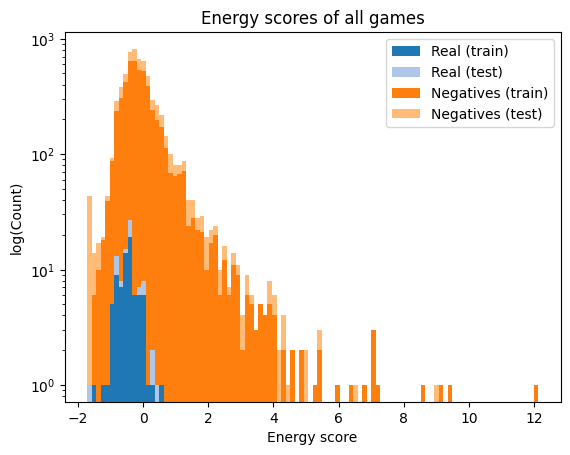

0.0020857207 0.020068603 4.6121598e-10


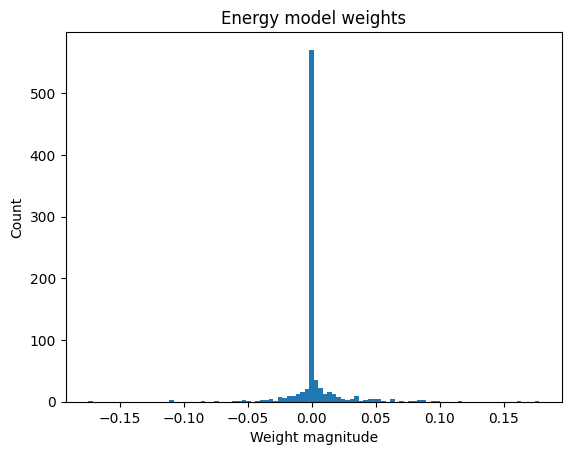

In [12]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    feature_columns=all_feature_columns, scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)  #, histogram_title_note='with `real` flag')

In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [13]:
# cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
utils.evaluate_energy_contributions(cv, train_tensor, 3621, feature_columns, full_tensor, real_game_texts, regrown_game_texts, top_k=5)

### Trying with binarized features

In [14]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_count_terminal', 'section_without_pref_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations'
]  

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+')
]   

def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.copy(deep=True)

    for c in binarized_df.columns:
        if c in ignore_columns:
            continue

        if c in BINARIZE_IGNORE_FEATURES:
            continue 
        
        if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
            continue

        if c in BINARIZE_NON_ONE:
            binarized_df[c] = (binarized_df[c] == 1).astype(int)

        if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
            binarized_df[c] = (binarized_df[c] != 0).astype(int)

    return binarized_df


binarized_df = binarize_features(fitness_df)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


### Test results:

{'ecdf': -0.28146153846153843, 'game_rank': 0.862500011920929}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
256,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.0,-0.235604,0.030221,1,0.855807,0.023090,743
512,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.0,-0.236098,0.037946,2,0.858372,0.023161,660
320,4,4,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.0,-0.236365,0.029428,3,0.852786,0.023323,818
264,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,0.0,-0.236611,0.029887,4,0.867448,0.018478,316
276,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.03,2,835,0.0,-0.236715,0.027023,5,0.861602,0.019393,563
192,2,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.0,-0.236809,0.026752,6,0.858086,0.019027,674
196,2,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,0.0,-0.236891,0.029105,7,0.862747,0.017604,521
516,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,0.0,-0.237245,0.031715,8,0.869453,0.022559,190
64,2,8,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.0,-0.237812,0.029214,9,0.856484,0.023967,720
588,4,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.0,-0.238010,0.030645,10,0.868841,0.017517,230


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
261,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,0.25,-0.261095,0.025953,376,0.873828,0.019650,1
517,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,2,835,0.25,-0.261096,0.025437,377,0.873802,0.018222,2
1219,16,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,2.00,-0.259447,0.026869,268,0.873776,0.018562,3
291,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.01,1,835,2.00,-0.262292,0.023720,524,0.873581,0.019158,4
525,4,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.25,-0.261154,0.025568,382,0.873581,0.018470,4
269,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.25,-0.261136,0.025974,380,0.873411,0.019543,6
265,2,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,0.25,-0.260939,0.025806,365,0.873242,0.019611,7
585,4,64,<function fitness_hinge_loss at 0x160e4a950>,0.10,4,835,0.25,-0.261803,0.025923,453,0.873021,0.019032,8
193,2,32,<function fitness_hinge_loss at 0x160e4a950>,0.10,1,835,0.25,-0.256907,0.024179,192,0.872878,0.019307,9
140,2,16,<function fitness_hinge_loss at 0x160e4a950>,0.10,8,835,0.00,-0.243962,0.025986,53,0.872695,0.016592,10


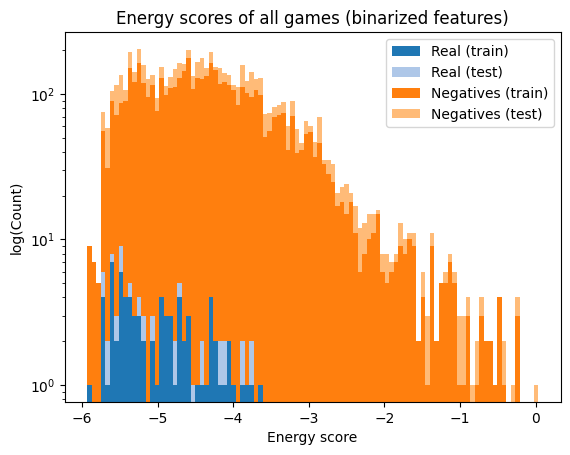

-0.0028041676 0.05808829 1.9185818e-07


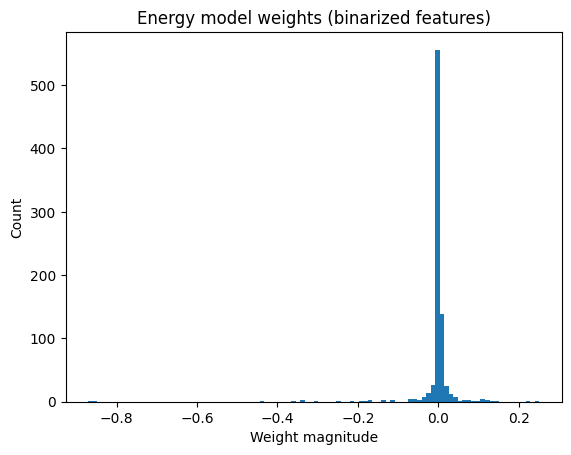

In [15]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_no_scaling, (train_tensor_no_scaling, test_tensor_no_scaling), test_results_no_scaling = utils.model_fitting_experiment(binarized_df, test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_no_scaling, train_tensor_no_scaling, test_tensor_no_scaling, test_results_no_scaling, histogram_title_note='binarized features')

In [16]:
SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv_no_scaling.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

## Alternative experiments

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_hybrid_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

# all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
# scaler_kwargs = dict(passthrough=True)
# model_kwargs = dict(output_activation=nn.Identity())
# train_kwargs = dict()
# cv_kwargs = dict(refit='single_game_rank')
# scoring = utils.build_multiple_scoring_function(
#     [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
#     ['overall_ecdf', 'single_game_rank'],
# )

# cv_no_scaling, (train_tensor_no_scaling, test_tensor_no_scaling), test_results_no_scaling = utils.model_fitting_experiment(fitness_df, test_param_grid,
#     scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
#     model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

# print(test_results_no_scaling)


# utils.visualize_cv_outputs(cv_no_scaling, train_tensor_no_scaling, test_tensor_no_scaling, test_results_no_scaling)

## Trying the old hinge loss, but with no negative averaging

In [ ]:
test_param_grid = [
    # {
    #     'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
    #     'fitness__weight_decay': [0.0, 0.25, 1, 2],  
    #     'fitness__margin': [1, 2, 4, 8],
    #     # 'fitness__beta': [0.25, 1, 2, 4],
    #     'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
    #     'fitness__k': [4, 8, 16, 32, 64],
    #     'fitness__batch_size': [4, 8, 16, 32],  # [1, 4, 8, 16],
    #     # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    # },
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, ],  
        'fitness__margin': [1, 2,],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2,],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [32, 64],
        'fitness__batch_size': [8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)